In [4]:
# en esta celda es solo inicialización: 
# se importan paquetes a utilizar y se definen funciones que serán requeridas más tarde. 
# Ver comentarios en cada unas de las funciones.


#esta línea indica que las figuras se muestren en el notebook
%matplotlib inline 

import numpy as np
from numpy import *
import scipy
from scipy.optimize import fmin_l_bfgs_b as fmin
import matplotlib.pyplot as plt
#import seaborn as sns #- uncomment this if you want to use seaborn for better-looking plots
import os
import time


def SE(a,b,gamma=1./2,sigma=1): 
	#Square Exponential kernel

	#returns the evaluation of the kernel
	#k(a,b)=sigma**2*exp(-gamma*(a-b)**2), 
	#notice that in this definition gamma = 1 /(2*lengthscale**2), in order to simplify the derivatives
	#for consistency with the generation of Gram matrices, this function returns
	#a matrix of dimensions dim(a) x dim(b);  
  
	#INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma)
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=exp(-(a[va]-b[vb])**2*gamma);
	if sa==1:
		return sigma**2*np.reshape(K,b.shape)
	elif sb==1:
		return sigma**2*np.reshape(K,a.shape)
	else:
		return sigma**2*K

#negative log-likelihood when using SE kernel
def like_SE(X, y, t): 

    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_noise, gamma_1, sig_1 = np.exp(X)     
	Gram=SE(t,t,gamma=gamma_1,sigma=sig_1)+sigma_noise**2*np.identity(len(t))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using SE kernel
def like_SE_Df(X, y, t):
    sigma_noise, gamma_1, sig_1 = np.exp(X)
    Gram0=SE(t,t,gamma=gamma_1,sigma=sig_1)
    Gram=Gram0+sigma_noise**2*np.identity(len(t))
    cGg=np.linalg.cholesky(Gram)
    invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
    A=np.dot(invGram,y)
    outer_sub=outersum(t,-t)
    D1=2*sigma_noise**2*np.identity(len(t)) #sigma_noise
    D2=-Gram0*outer_sub**2*gamma_1 #gamma_1
    D3=2*Gram0 #sig_1 

    B=np.outer(A,A)-invGram
    d1=  -np.trace(np.dot(B,D1))
    d2=  -np.trace(np.dot(B,D2))
    d3=  -np.trace(np.dot(B,D3))

    print(['Derivatives: ', d1, d2, d3])
    return np.asarray([0.5*d1, 0.5*d2, 0.5*d3])
    
# "suma" externa
def outersum(a,b):
	return np.outer(a,ones_like(b))+np.outer(ones_like(a),b)

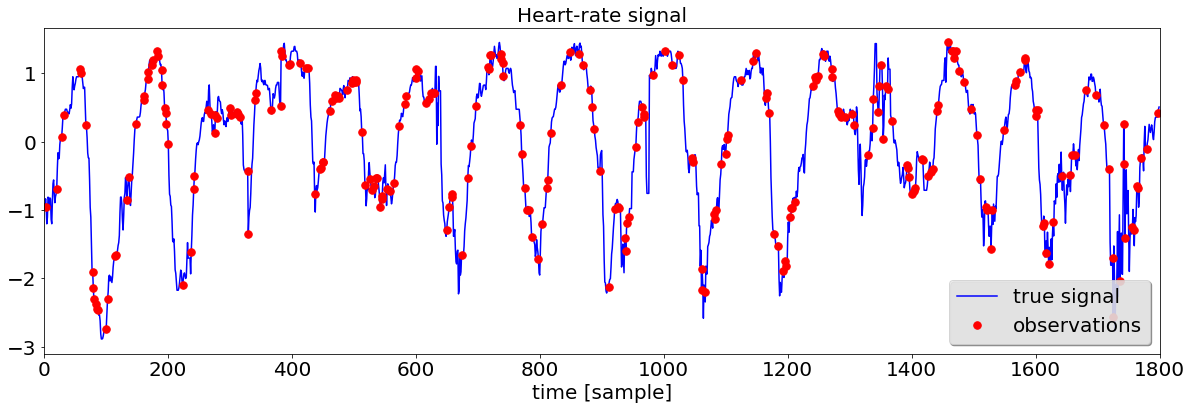

In [5]:
# Esta celda lee datos del archivo hr2.txt, los que corresponden a una señal de frecuencia cardíaca.
# Luego, se elige un subconjunto de los valores de la señal que representa las observaciones disponibles
# la señal completa es graficada en negro y las observaciones en rojo

my_label_size = 20
label_size = 20
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 


hr=[] #init array
for line in open('hr2.txt', 'r'): #abre archivo
	item = line.rstrip() 	# lee línea
	hr.append(float(item)) #convierte a float
y=np.asarray(hr); 
y=y-np.mean(y); 
y=y/std(y)  # convierte a array y normaliza (opcional)
f=y #señal es igual a versión ruidosa
N=len(y); T0=0; TF=N # inicio, fin y tamaño
t=np.arange(N) #vector de tiempo

#elección (aleatoria)del 15% de las muestras 
i_obs=np.random.choice(arange(0,N,1),int(0.15*N),replace=False)
N_obs=len(i_obs)
t_obs=t[i_obs]
y_obs=y[i_obs]#; y_obs.reshape(N_obs,1)

#gráfico
fig=plt.figure(1, figsize=(20,6))
ax = plt.gca()
plt.plot(t,f, color='b',ls='-',label='true signal')
plt.plot(t_obs,y_obs,'red',ms=15, linestyle='none', marker='.', label='observations')
ax.axis('tight')
leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlim([0,1800])
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Heart-rate signal', fontsize=my_label_size)


La señal de frecuencia cardíaca $y(t)$ será modelada mediante un GP con kernel SE y observaciones gaussianas, es decir,
\begin{align}
y(t) & = f(t) + \epsilon(t), \epsilon(t)\sim(N,\sigma_y)\\
f(\cdot) & \sim GP(0,K_{SE})\\
K_{SE}(t_1,t_2) & = \sigma^2\exp\left(-\gamma(t_1-t_2)^2\right)
\end{align}
donde $y$ es la señal observada, $f$ el GP latente, y $\epsilon$ el ruido de observación.

Consecuentemente, la distribución de un valor no observado $y(t)\in\mathbf{R}$ de la señal condicional a los valores observados $y_{obs}\in\mathbf{R}^N$ en los instantes $t_{obs}\in\mathbf{R}^N$ es gaussiano con media y varianza dadas respectivamente por
\begin{align}
\mathbb{E}(y_{obs}) &= K_{SE}(t,t_{obs})K_{SE}^{-1}(t_{obs},t_{obs})y_{obs}\\
\text{var}(y_{obs}) &= K_{SE}(t,t) - K_{SE}(t,t_{obs})K_{SE}^{-1}(t_{obs},t_{obs})K_{SE}(t_{obs},t)
\end{align}
 
Recuerde que estos estadísticos dependen de la elección de los hiperparámetros $\sigma, \gamma$ y $\sigma_y$. Una medida de ajuste de estos hiperparámetros a los datos está dada por la probabilidad de los datos bajo los hiperparámetros, esta probabilidad es también conocida como verosimilitud de los hiperparámetros y está dada por


$$ L(\sigma, \gamma, \sigma_y\vert y_{obs},t_{obs}) = p ( y_{obs},t_{obs} \vert \sigma, \gamma, \sigma_y) = \frac{1}{(2 \pi)^N |K(t_{obs},t_{obs})|}\exp\left(\frac{-1}{2} y_{obs}^T  K(t_{obs},t_{obs}) ^{-1}y_{obs}\right)$$

A continuación Ud. deberá experimentar con distintas combinaciones de hiperparámetros, para los cuales deberá evaluar la función de log-verosimilitud negativa (NLL) y graficar su la estimación con dicha elección de hiperparámetros. Pruebe distintas combinaciones de hiperparámetros en las tres primeras líneas de la siguiente celda y luego ejecútela, recuerde que a menor NLL, más probable es que los datos observados hayan sido generados por un modelo con los hiperparámetros elegidos. Un buen punto de partido son los valores dados en el código.

Comente en base a al gráfico de la estimación y sus valores de la NLL obtenida

Negative log-likelihood para hiperámetros escogidos:  554.237815647


(0, 1800)

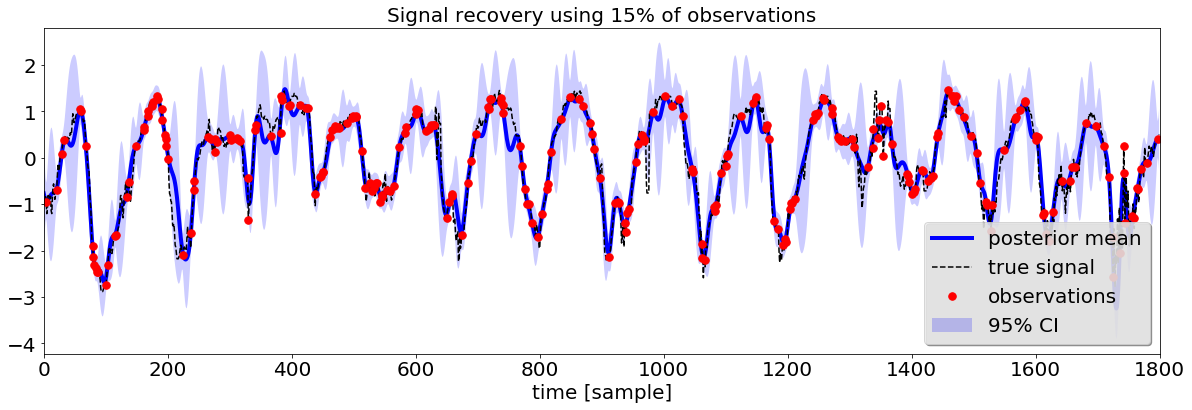

In [6]:
#elegir hiperparámetros
sigma_y_GP_test = 0.2
gamma_test = 0.01
sigma_test= 1

#NLL para la elección de hiperparámetros 
print('Negative log-likelihood para hiperámetros escogidos: ',like_SE([sigma_y_GP_test, gamma_test, sigma_test], y_obs, t_obs))

#covarianza a priori del proceso
cov=SE(t,t,gamma=gamma_test,sigma=sigma_test)

#covarianza a priori de las observaciones
cov_obs=SE(t_obs,t_obs,gamma=gamma_test,sigma=sigma_test)

#evaluación kernel entre observaciones y puntos a estimar
K_star=SE(t,t_obs,gamma=gamma_test,sigma=sigma_test)

#cholesky
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))

#inversa matriz de covarianza (Gram)
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))

temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='b',lw=4,label='posterior mean')
plt.fill_between(t, y_model-2*std_dev, y_model+2*std_dev, facecolor='blue', alpha=0.2, label='95% CI')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'red',ms=15, linestyle='none', marker='.', label='observations')
leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Signal recovery using 15% of observations', fontsize=my_label_size)
plt.xlim([0,1800])

En la siguiente celda se entrena el GP usando máxima verosimilitud mediante L_BFGS_B (con derivadas de la NLL explícitas). Revise y entienda la sintaxis del llamado al optimizador, ejecute y comente. 

In [7]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([2,  .1,  1])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_SE,X0,like_SE_Df, args,disp=1,factr=0.00000001/(2.22E-12),maxiter=50)
time_GP=time.time()-time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt))

print('Negative log-likelihood para hiperámetros optimizados: ', f_GP)

Condicion inicial optimizador:  [ 2.   0.1  1. ]
['Derivatives: ', 372.41848146867295, 4.2317037662226369, 71.422585630590021]
['Derivatives: ', 166.3823665096491, 29.794499362003705, 43.894339539437603]
['Derivatives: ', 50.860200616887383, 75.866381206065668, -242.77305842894953]
['Derivatives: ', 40.934673909553887, 86.531143787029464, -71.443878491898886]
['Derivatives: ', -180.66452661340884, -690.65404535745267, -295.83357478423534]
['Derivatives: ', -6.584801177613091, 51.449946942779697, -0.43256991950217127]
['Derivatives: ', -63.052062019256624, -34.725087939884077, -72.834798043828926]
['Derivatives: ', -25.547363800315107, 18.198606273252643, -31.543883842757957]
['Derivatives: ', -35.939924416358963, 20.178526174935804, -25.244652209114165]
['Derivatives: ', 49.836216086358739, 87.093340560527793, 56.583304117668675]
['Derivatives: ', 539.97199800587782, 1.964819733484954e-06, 0.013219394084917159]
['Derivatives: ', 92.102060522546168, 89.890594585269966, 61.64172161687780

(0, 1800)

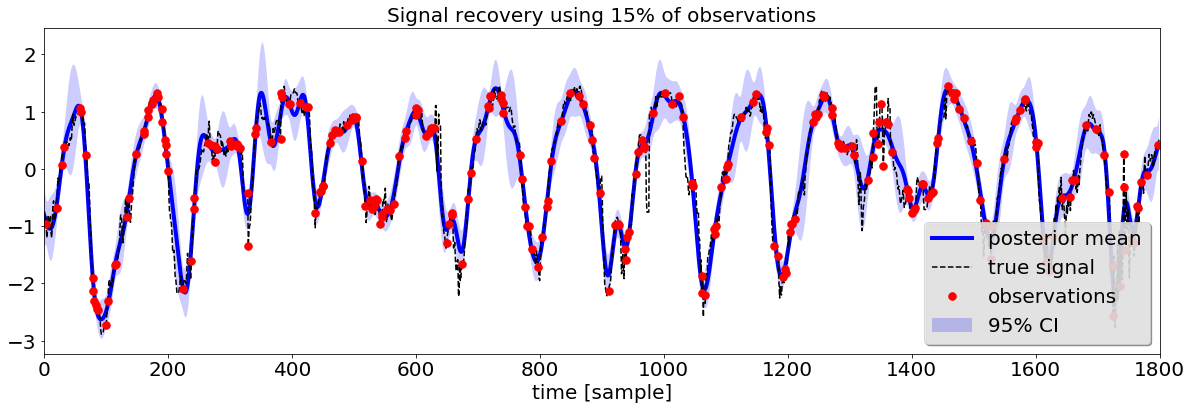

In [8]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud

cov=SE(t,t,gamma=gamma_1,sigma=sig_1)
cov_obs=SE(t_obs,t_obs,gamma=gamma_1,sigma=sig_1)
K_star=SE(t,t_obs,gamma=gamma_1,sigma=sig_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#plotear estimacion, observaciones y datos totales
fig=plt.figure(3, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='b',lw=4,label='posterior mean')
plt.fill_between(t, y_model-2*std_dev, y_model+2*std_dev, facecolor='blue', alpha=0.2, label='95% CI')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'red',ms=15, linestyle='none', marker='.', label='observations')
leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Signal recovery using 15% of observations', fontsize=my_label_size)
plt.xlim([0,1800])



# Enunciado Tarea

Replique los resultados generados usando diferentes kernels tales como: Rational quadratic, Spectral Mixture, Locally Periodic Kernel, Matern, etc, de acuerdo al siguiente procedimiento:
        
1) defina el nuevo kernel a usar de la forma: def NuevoKernel(a,b,param1, param2,param3,etc)

2) defina la log-verosimilitud negativa: def like_NuevoKernel((X, y, t)) (donde X son los hiperparámetros)

3) pruebe manualmente hiperparámetros 

4) encuentre los hiperparametros minimizando like_NuevoKernel 

5) compare todos los kernels implementados en función de su estimación (gráfico), NLL y tiempo de entrenamiento.

NOTA 1:  L_BFGS_B puede ser usado sin entregar la expresión de la derivada de la función a minimizar, pero entregar las derivadas es buena práctica

NOTA 2: para evitar imponer restricciones en el optimizador (por ejemplo para parámetros que únicamente pueden ser positivos) re-parametrize dichos parámetros usando $\theta_{new} \leftarrow \exp(\theta_{old})$


In [106]:
def RationalQuadratic(a,b,sigma, alpha,l):
    
    #INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]=(sigma**2)*(1+((a[va]-b[vb])**2)/(2*alpha*l**2))**(-alpha)
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=(sigma**2)*(1+((a[va]-b[vb])**2)/(2*alpha*l**2))**(-alpha)
	if sa==1:
		return np.reshape(K,b.shape)
	elif sb==1:
		return np.reshape(K,a.shape)
	else:
		return K
    
#negative log-likelihood when using SE kernel
def like_RQ(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_noise, l_1, sig_1, alpha_1 = np.exp(X)     
	Gram=RationalQuadratic(t,t,sigma=sig_1,alpha=alpha_1, l=l_1)+sigma_noise**2*np.identity(len(t))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using SE kernel
def like_RQ_Df(X, y, t):
    sigma_noise, l_1, sig_1, alpha_1 = np.exp(X) 
    Gram0=RationalQuadratic(t,t,sigma=sig_1,alpha=alpha_1, l=l_1)
    Gram=Gram0+sigma_noise**2*np.identity(len(t))
    cGg=np.linalg.cholesky(Gram)
    invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
    A=np.dot(invGram,y)
    outer_sub=outersum(t,-t)


    D1= 2*sigma_noise**2*np.identity(len(t)) #sigma_noise
    D2= outer_sub**2*Gram0*Gram0**(1.0/alpha_1)/(l_1**3*sig_1**(2.0/alpha_1)) #l_1
    D3= 2*Gram0/sig_1 #sig_1
    D4= Gram0*(1-2*alpha_1*l_1**2/(outer_sub**2+2*alpha_1*l_1**2) - log(Gram0)/(-1.0*alpha_1)) #alpha_1

    B=np.outer(A,A)-invGram
    d1=  -np.trace(np.dot(B,D1))
    d2=  -np.trace(np.dot(B,D2))
    d3=  -np.trace(np.dot(B,D3))
    d4=  -np.trace(np.dot(B,D4))
    print(['Derivatives: ', d1, d2, d3, d4])
    return np.asarray([0.5*d1, 0.5*d2, 0.5*d3, 0.5*d4])

Negative log-likelihood para hiperámetros escogidos:  189.179540966


(0, 1800)

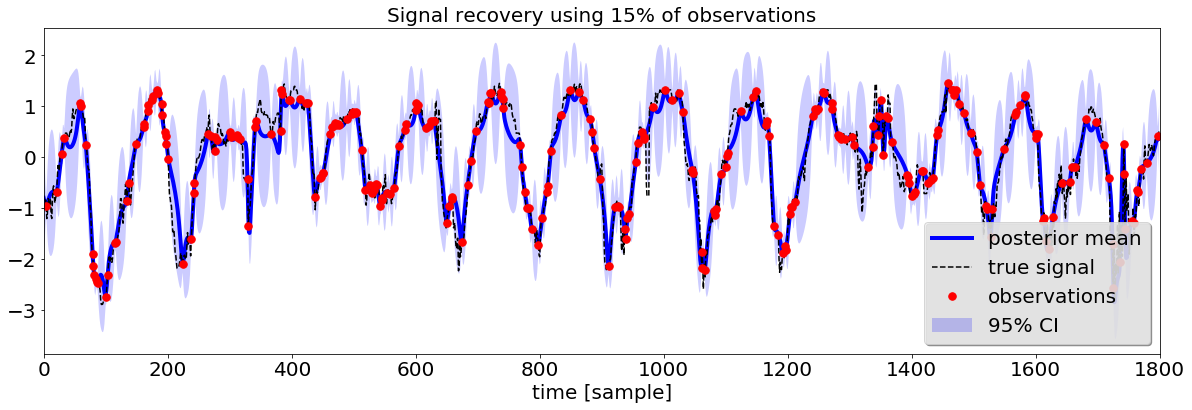

In [98]:
#elegir hiperparámetros
sigma_y_GP_test = np.log(0.1)
l_test = np.log(5.6)
sigma_test= np.log(1)
alpha_test= np.log(0.19)

#NLL para la elección de hiperparámetros 
print('Negative log-likelihood para hiperámetros escogidos: ',like_RQ([sigma_y_GP_test, l_test, sigma_test, alpha_test], y_obs, t_obs))


sigma_y_GP_test = np.exp(sigma_y_GP_test)
l_test = np.exp(l_test)
sigma_test= np.exp(sigma_test)
alpha_test= np.exp(alpha_test)

#covarianza a priori del proceso
cov=RationalQuadratic(t,t,sigma=sigma_test,alpha=alpha_test, l = l_test)

#covarianza a priori de las observaciones
cov_obs=RationalQuadratic(t_obs,t_obs,sigma=sigma_test,alpha=alpha_test, l = l_test)

#evaluación kernel entre observaciones y puntos a estimar
K_star=RationalQuadratic(t,t_obs,sigma=sigma_test,alpha=alpha_test, l = l_test)

#cholesky
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP_test**2*np.identity(N_obs))

#inversa matriz de covarianza (Gram)
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))

temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)


#graficar estimación, observaciones y datos reales
fig=plt.figure(2, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='b',lw=4,label='posterior mean')
plt.fill_between(t, y_model-2*std_dev, y_model+2*std_dev, facecolor='blue', alpha=0.2, label='95% CI')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'red',ms=15, linestyle='none', marker='.', label='observations')
leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Signal recovery using 15% of observations', fontsize=my_label_size)
plt.xlim([0,1800])

In [119]:
#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(y_obs,t_obs)
time_SE=0
params0=np.asarray([0.1,  5.6, 1, 0.2])
X0=np.log(params0);
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_RQ,X0,like_RQ_Df, args,disp=1,factr=0.000000000000000001/(2.22E-12),maxiter=100)
time_GP=time.time()-time_GP
sigma_noise, l_1, sig_1, alpha_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt))

print('Negative log-likelihood para hiperámetros optimizados: ', f_GP)

Condicion inicial optimizador:  [ 0.1  5.6  1.   0.2]
['Derivatives: ', -2.8185305613450966, -9.5675985204021643, 10.78834144006143, -26.499507308547891]
['Derivatives: ', 6.3343746323680641, -4.4286915306990124, 327.97476613861954, 198.081744233976]
['Derivatives: ', 15.875514058070456, -15.32408802241445, 68.962053138723363, 33.416236138176323]
['Derivatives: ', -1.9881779272451636, -9.7928355718450906, 11.875051219429352, -26.862106126646495]
['Derivatives: ', -1.2082266113989824, -10.006149498441344, 12.946196057599408, -27.105926544630336]
['Derivatives: ', 12.011465255296869, -13.964273916965649, 44.538975975347419, -4.4557665775693209]
['Derivatives: ', -0.65223996109622284, -10.15927603054935, 13.741376916826979, -27.218741356177503]
['Derivatives: ', -0.13586749496062822, -10.30230900328417, 14.504739223201796, -27.27541629331273]
['Derivatives: ', 7.7954345968038812, -12.615454764094453, 30.375341488303633, -19.951966607211048]
['Derivatives: ', 0.26580457805912783, -10.41412

(0, 1800)

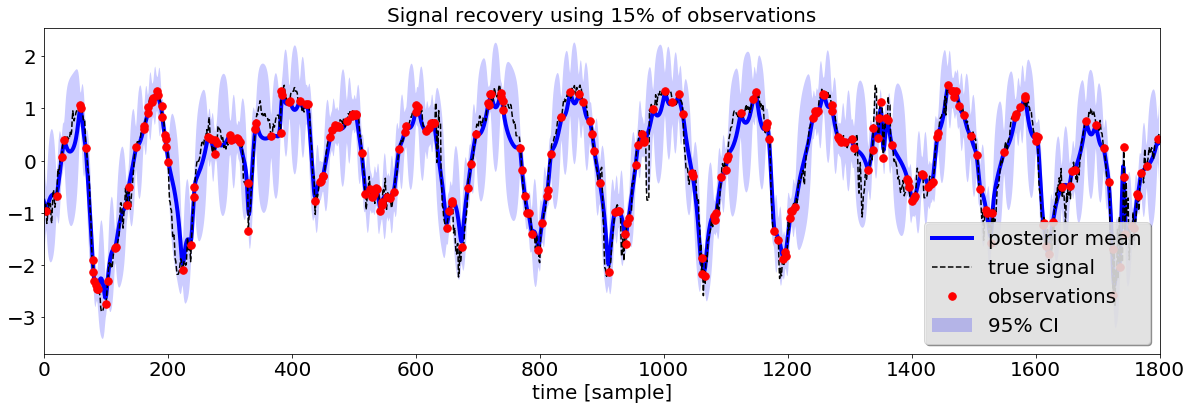

In [120]:
#Graficar nuevamente con los hiperparámetros encontrados mediante máxima verosimilitud

cov=RationalQuadratic(t,t,sigma=sig_1,alpha=alpha_1, l=l_1)
cov_obs=RationalQuadratic(t_obs,t_obs,sigma=sig_1,alpha=alpha_1, l=l_1)
K_star=RationalQuadratic(t,t_obs,sigma=sig_1,alpha=alpha_1, l=l_1)
cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.dot(K_star,invGramg)
y_model=np.dot(temp,y_obs)
v_model=np.diag(cov-np.dot(temp,K_star.T))
std_dev=np.sqrt(v_model)

#plotear estimacion, observaciones y datos totales
fig=plt.figure(3, figsize=(20,6))
ax = plt.gca()
plt.plot(t,y_model,c='b',lw=4,label='posterior mean')
plt.fill_between(t, y_model-2*std_dev, y_model+2*std_dev, facecolor='blue', alpha=0.2, label='95% CI')
plt.plot(t,f, color='black',ls='--',label='true signal')
plt.plot(t_obs,y_obs,'red',ms=15, linestyle='none', marker='.', label='observations')
leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Signal recovery using 15% of observations', fontsize=my_label_size)
plt.xlim([0,1800])

In [ ]:
def SpectralMixture(a,b,sigma,mu):
    
    #INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]= exp(-2.0*(pi**2)*(a[va]-b[vb])*sigma**2)*cos(2*pi*(a[va]-b[vb])*mu)
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=exp(-2.0*(pi**2)*(a[va]-b[vb])*sigma**2)*cos(2*pi*(a[va]-b[vb])*mu)
	if sa==1:
		return np.reshape(K,b.shape)
	elif sb==1:
		return np.reshape(K,a.shape)
	else:
		return K

#negative log-likelihood when using SE kernel
def like_SM(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
	sigma_noise, sig_1, mu_1 = np.exp(X)     
	Gram=SpectralMixture(t,t,sigma=sig_1, mu=mu_1)+sigma_noise**2*np.identity(len(t))
	cGg=np.linalg.cholesky(Gram)
	invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
	nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
	return 0.5*nll+0.5*len(y)*np.log(2*pi)

#derivative of negative log-likelihood when using SE kernel
def like_RQ_Df(X, y, t):
    sigma_noise, l_1, sig_1, alpha_1 = np.exp(X) 
    Gram0=RationalQuadratic(t,t,sigma=sig_1,alpha=alpha_1, l=l_1)
    Gram=Gram0+sigma_noise**2*np.identity(len(t))
    cGg=np.linalg.cholesky(Gram)
    invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
    A=np.dot(invGram,y)
    outer_sub=outersum(t,-t)


    D1= 2*sigma_noise**2*np.identity(len(t)) #sigma_noise
    D2= outer_sub**2*Gram0*Gram0**(1.0/alpha_1)/(l_1**3*sig_1**(2.0/alpha_1)) #l_1
    D3= 2*Gram0/sig_1 #sig_1
    D4= Gram0*(1-2*alpha_1*l_1**2/(outer_sub**2+2*alpha_1*l_1**2) - log(Gram0)/(-1.0*alpha_1)) #alpha_1

    B=np.outer(A,A)-invGram
    d1=  -np.trace(np.dot(B,D1))
    d2=  -np.trace(np.dot(B,D2))
    d3=  -np.trace(np.dot(B,D3))
    d4=  -np.trace(np.dot(B,D4))
    print(['Derivatives: ', d1, d2, d3, d4])
    return np.asarray([0.5*d1, 0.5*d2, 0.5*d3, 0.5*d4])

In [ ]:
def LocallyPeriodic(a,b,sigma,p,l):
    
    #INPUTS
	#a,b are column vectors of (possibly) different lenghts
	sa=np.size(a); sb=np.size(b)

	if sa==1: a=np.array([a])
	if sb==1: b=np.array([b])
	K=np.zeros([sa,sb])(
	#accelerate computation if a==b
	if np.array_equal(a,b):
		for va in range(sa):
			K[va,va]=1;
			for vb in range(va+1,sb):
				K[va,vb]= (sigma**2)*exp(-(2*sin(pi*abs(a[va]-b[vb])/p)**2)/(l**2))*exp(-((a[va]-b[vb])**2)/(2*l**2))
				K[vb,va]=K[va,vb]
	#a!=b
	else:
		for va in range(sa):
			for vb in range(sb):
				K[va,vb]=(sigma**2)*exp(-(2*sin(pi*abs(a[va]-b[vb])/p)**2)/(l**2))*exp(-((a[va]-b[vb])**2)/(2*l**2))
    if sa==1:
		return np.reshape(K,b.shape)
	elif sb==1:
		return np.reshape(K,a.shape)
	else:
		return K